# Kaggle Real or Not? NLP with Disaster Tweets
I am learning from https://www.kaggle.com/marcovasquez/basic-nlp-with-tensorflow-and-wordcloud/notebook

In [ ]:
import pandas as pd
import numpy as np
import tokenization
from wordcloud import STOPWORDS
import re
import nltk   
from nltk.corpus import stopwords 
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report,confusion_matrix


In [165]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

Compute the number of words in a tweet. After compute the number of unique words.

In [166]:
train_df['wordsCount'] = train_df.text.apply(lambda x: len(x.split()))
test_df['wordsCount'] = test_df.text.apply(lambda x: len(x.split()))

In [167]:
train_df['uniqueWordsCount'] = train_df.text.apply(lambda x: len(set(x.split())))
test_df['uniqueWordsCount'] = test_df.text.apply(lambda x: len(set(x.split())))

In [168]:
train_df['stopWordsCount'] = train_df.text.apply(lambda x: len([word for word in x.lower().split() if word in STOPWORDS]))
test_df['stopWordsCount'] = test_df.text.apply(lambda x: len([word for word in x.lower().split() if word in STOPWORDS]))

In [169]:
# Remove websites from tweet
pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
def remove_html(text):
    no_html= pattern.sub('',text)
    return no_html

In [170]:
# Remove stopwords and words with 1 letter
def clean_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = text.split()
    return ' '.join([word for word in text if (word not in STOPWORDS and len(word)>1)])

In [171]:
train_df['cleanedText'] = train_df.text.apply(lambda x: remove_html(x)).apply(lambda x: clean_text(x))
test_df['cleanedText'] = test_df.text.apply(lambda x: remove_html(x)).apply(lambda x: clean_text(x))

In [172]:
train_df.head()

,id,keyword,location,text,target,wordsCount,uniqueWordsCount,stopWordsCount,cleanedText
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,13,6,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,7,0,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,20,11,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,8,1,people receive wildfires evacuation orders cal...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,15,7,got sent photo ruby alaska smoke wildfires pou...


In [173]:
counter = Counter()

In [174]:
allWords = train_df['cleanedText'].str.split().sum()

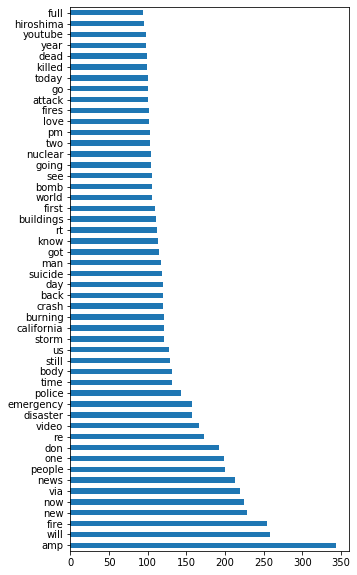

In [175]:
pd.Series(allWords).value_counts().head(50).plot.barh(figsize=(5,10))

In [176]:
print('Number of unique words: ', len(set(allWords)))

Number of unique words:  16056


In [177]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=False)

In [178]:
tokenizer.fit_on_texts(allWords)

In [179]:
tokenizer.texts_to_sequences(["amp News"])

[[1, 7]]

In [180]:
tokenizer.texts_to_sequences([train_df['cleanedText'][0]])
max_id = len(tokenizer.word_index) # number of distinct words
dataset_size = tokenizer.document_count # total number of words

In [181]:
[encoded] = np.array(tokenizer.texts_to_sequences([allWords])) - 1

In [182]:
train_size = dataset_size * 90 // 100
train_size

62202

In [183]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

In [184]:
n_steps = 100
window_length = n_steps + 1 # target = input shifted 1 character ahead
dataset = dataset.window(window_length, shift=1, drop_remainder=True)

In [185]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [186]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

In [187]:
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

In [188]:
dataset = dataset.prefetch(1)

In [189]:
model = keras.models.Sequential([
    keras.layers.GRU(10, return_sequences=True, input_shape=[None, max_id],
                     dropout=0.2, recurrent_dropout=0.2),
    keras.layers.GRU(10, return_sequences=True,
                     dropout=0.2, recurrent_dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, epochs=1)

     11/Unknown - 59s 5s/step - loss: 9.6783

KeyboardInterrupt: 

In [190]:
vocab_size = len(set(allWords))
embedding_dim = 32

# Max number of words in each complaint.
max_length = 20
trunc_type='post'
padding_type='post'

# oov_took its set for words out our word index
oov_tok = "<XXX>"
training_size = 6090
seq_len = 12

In [191]:
# this is base in 80% of the data, an only text and target at this moment

training_sentences = train_df.cleanedText[0:training_size]
training_labels = train_df.target[0:training_size]

validation_sentences = train_df.cleanedText[training_size:]
validation_labels = train_df.target[training_size:]

In [192]:
print('The Shape of training ',training_sentences.shape)
print('The Shape of validation',validation_sentences.shape)

The Shape of training  (6090,)
The Shape of validation (1523,)


In [193]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

In [194]:
word_index = tokenizer.word_index

In [195]:
# Lets see the first 10 elements
print("The first word Index are: ")
for x in list(word_index)[0:10]:
    print (" {},  {} ".format(x,  word_index[x]))

The first word Index are: 
 <XXX>,  1 
 amp,  2 
 fire,  3 
 will,  4 
 via,  5 
 new,  6 
 now,  7 
 people,  8 
 news,  9 
 don,  10 


In [196]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [197]:
training_padded[1]

array([  72,    3,  120,  564, 5468, 5469, 1173,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0])

In [198]:
print(train_df.text[1])
print(training_sequences[1])

Forest fire near La Ronge Sask. Canada
[72, 3, 120, 564, 5468, 5469, 1173]


In [199]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [200]:
def decode(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [201]:
decode(training_sequences[1]) # this can be usefull for check predictions

'forest fire near la ronge sask canada'

In [202]:
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [203]:
# Model Definition with LSTM

model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(128)),
    keras.layers.Dense(6, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')  # remember this is a binary clasification
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [204]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 20, 32)            513792    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 256)               164864    
_________________________________________________________________
dense_17 (Dense)             (None, 6)                 1542      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 7         
Total params: 680,205
Trainable params: 680,205
Non-trainable params: 0
_________________________________________________________________


In [205]:
history = model.fit(training_padded, training_labels.values, epochs=10, validation_data=(validation_padded, validation_labels.values))

Train on 6090 samples, validate on 1523 samples
Epoch 1/10
6090/6090 [==============================] - 28s 5ms/sample - loss: 0.5718 - accuracy: 0.7026 - val_loss: 0.4564 - val_accuracy: 0.8056
Epoch 2/10
6090/6090 [==============================] - 12s 2ms/sample - loss: 0.3033 - accuracy: 0.8869 - val_loss: 0.4990 - val_accuracy: 0.7446
Epoch 3/10
6090/6090 [==============================] - 11s 2ms/sample - loss: 0.1738 - accuracy: 0.9476 - val_loss: 0.5393 - val_accuracy: 0.7663
Epoch 4/10
6090/6090 [==============================] - 11s 2ms/sample - loss: 0.1338 - accuracy: 0.9598 - val_loss: 0.5826 - val_accuracy: 0.7531
Epoch 5/10
6090/6090 [==============================] - 14s 2ms/sample - loss: 0.1085 - accuracy: 0.9688 - val_loss: 0.6590 - val_accuracy: 0.7525
Epoch 6/10
6090/6090 [==============================] - 13s 2ms/sample - loss: 0.0895 - accuracy: 0.9744 - val_loss: 0.7202 - val_accuracy: 0.7288
Epoch 7/10
6090/6090 [==============================] - 12s 2ms/sample

In [206]:
model_loss = pd.DataFrame(model.history.history)
model_loss.head()

,loss,accuracy,val_loss,val_accuracy
0,0.571779,0.702627,0.456450,0.805647
1,0.303338,0.886864,0.498960,0.744583
2,0.173800,0.947619,0.539328,0.766251
3,0.133805,0.959770,0.582552,0.753119
4,0.108497,0.968801,0.658975,0.752462


In [207]:
predictions = model.predict_classes(validation_padded)   # predict_ clases because is classification problem with the split test

In [208]:
predictions

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [209]:
cm = confusion_matrix(validation_labels, predictions, labels=np.unique(validation_labels))

In [210]:
pd.DataFrame(cm)

,0,1
0,650,164
1,260,449


In [218]:
from sklearn.metrics import f1_score
f1_score(validation_labels, predictions)

0.6792738275340393

In [212]:
test_sequences = tokenizer.texts_to_sequences(test_df.cleanedText)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [213]:
sentence = pad_sequences(tokenizer.texts_to_sequences(["There's a fire and earthquake at Saskatoon"]), maxlen=max_length, padding=padding_type, truncating=trunc_type)
sentence

array([[  1,   1,   3,   1, 254,   1,   1,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0]])

In [214]:
test_predict = model.predict_classes(test_padded)
test_predict

array([[0],
       [0],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [216]:
df_out = pd.concat([test_df,pd.DataFrame(test_predict, columns=['target'])],axis=1)
df_out

,id,keyword,location,text,wordsCount,uniqueWordsCount,stopWordsCount,cleanedText,target
0,0,NaN,NaN,Just happened a terrible car crash,6,6,2,happened terrible car crash,0
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",9,9,2,heard earthquake different cities stay safe ev...,0
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",19,19,10,forest fire spot pond geese fleeing across str...,1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,4,4,0,apocalypse lighting spokane wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,8,8,2,typhoon soudelor kills china taiwan,1
...,...,...,...,...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,8,7,0,earthquake safety los angeles safety fasteners...,1
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,23,22,7,storm ri worse last hurricane city amp others ...,1
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,6,6,1,green line derailment chicago,1
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,7,7,0,meg issues hazardous weather outlook hwo,1


In [217]:
df_out[df_out['target']==1]['cleanedText']

2       forest fire spot pond geese fleeing across str...
3                   apocalypse lighting spokane wildfires
4                     typhoon soudelor kills china taiwan
5                                   re shaking earthquake
15      birmingham wholesale market ablaze bbc news fi...
                              ...                        
3258    earthquake safety los angeles safety fasteners...
3259    storm ri worse last hurricane city amp others ...
3260                        green line derailment chicago
3261             meg issues hazardous weather outlook hwo
3262    cityofcalgary activated municipal emergency pl...
Name: cleanedText, Length: 1170, dtype: object